<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Pyro - Bayesian Neural Net regression
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
import torch
import torch.nn as nn
# import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
# from pyro.nn import PyroModule, PyroParam, PyroSample, PyroModuleList
# from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import MCMC, NUTS
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
# import pyro.poutine as poutine
from pyro.infer import Predictive

from bnn_model import BayesianMLP

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    # if using a GPU (CUDA) and num_chains > 1
    torch.multiprocessing.set_start_method('spawn', force=True)
else:
    device = torch.device('cpu')
    
# NB Warning : setting the default_device to CUDA creates a device conflict
# when using a DataLoader, as it uses a CPU-generator for shuffling
torch.set_default_device(device)

print(f"Using {device}")
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

torch.set_default_dtype(torch.float32)

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
0 : Generate synthetic data
</div>

In [4]:
def target_function(X:torch.Tensor) -> torch.Tensor:
    y = X * torch.sin(16*torch.pi*X)
    return y

N_POINTS = 500

noise = torch.tensor([0.15])
X = torch.linspace(0.0, 1.0, steps=N_POINTS)
y = target_function(X) + torch.randn(N_POINTS)*noise

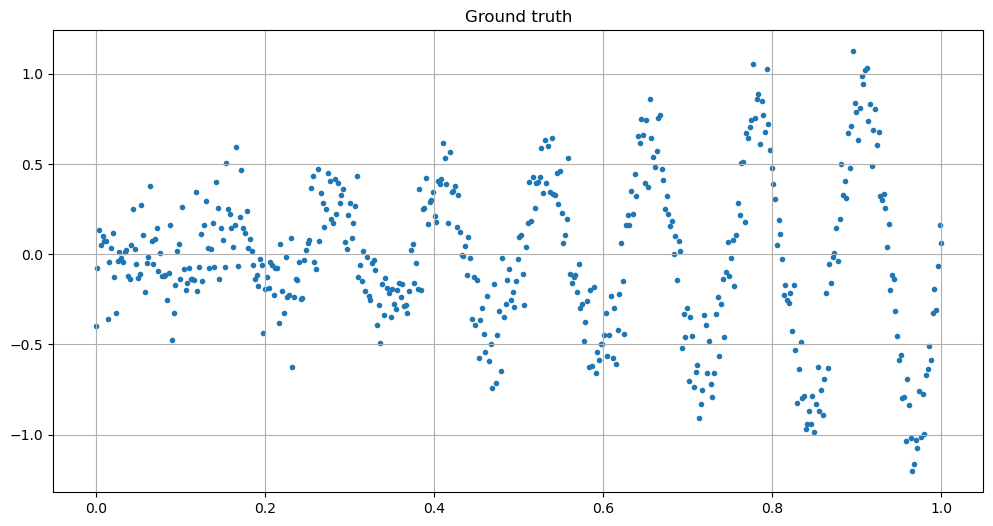

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(X.cpu(),y.cpu(),label='ground truth', marker='.')
ax.grid()
ax.set_title(f'Ground truth')
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
1 : Bayesian Neural Network with a Pyro model 
</div>

The idea is to consider all the network parameters (weights and biases) as random variables.

In [6]:
# # separate class definition to run mutli chain MCMC

# # Bayesian Neural Network
# class BayesianMLP(PyroModule):
#     """
#     The usual basic MLP class, but the Bayesian way
#     """
#     def __init__(self, n_layers=0, n_hidden_units=32, activation=nn.Tanh(), input_dim=1, output_dim=1, device='cpu', *args, **kwargs) -> None:
#         super().__init__(*args, **kwargs)
#         self.n_layers = n_layers
#         self.n_hidden_units = n_hidden_units
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.activation = activation
#         self.device = device    
        
#         # set tensors explicitly on the device for multi-chain
#         loc_prior = torch.tensor(0., device=self.device)
#         scale_prior = torch.tensor(1., device=self.device)
#         noise_loc = torch.tensor(-2.0, device=self.device)
#         noise_scale = torch.tensor(0.1, device=self.device)
        
#         self.layers = PyroModuleList([])
#         layer_input_dim = self.input_dim
#         for _ in range(self.n_layers+1):
#             bayesian_fc = PyroModule[nn.Linear](layer_input_dim, self.n_hidden_units)
#             bayesian_fc.weight = PyroSample(dist.Normal(loc_prior,scale_prior).expand(bayesian_fc.weight.shape).to_event(bayesian_fc.weight.dim()))
#             bayesian_fc.bias = PyroSample(dist.Normal(loc_prior, scale_prior).expand(bayesian_fc.bias.shape).to_event(bayesian_fc.bias.dim()))
#             self.layers.append(bayesian_fc)
#             layer_input_dim = self.n_hidden_units
            
#         # last layer
#         self.last_layer = PyroModule[nn.Linear](self.n_hidden_units, self.output_dim) 
#         self.last_layer.weight = PyroSample(dist.Normal(loc_prior,scale_prior).expand(self.last_layer.weight.shape).to_event(self.last_layer.weight.dim()))
#         self.last_layer.bias = PyroSample(dist.Normal(loc_prior,scale_prior).expand(self.last_layer.bias.shape).to_event(self.last_layer.bias.dim()))     
        
#         # noise term
#         self.log_sigma = PyroSample(dist.Normal(noise_loc,noise_scale))
        
#         # In Pyro, when you use PyroSample as an attribute of a PyroModule, 
#         # the attribute name itself (self.log_sigma in this case) becomes the name of the stochastic site in the model's trace. 
#         # Therefore, you should not pass the name as a string argument to PyroSample.   
        
#     def forward(self,x, y=None):
#         x = x.reshape(-1,1)
#         for layer in self.layers:
#             x = self.activation(layer(x))
#         mu = self.last_layer(x).squeeze()
        
#         sigma = torch.exp(self.log_sigma)
        
#         with pyro.plate("data", len(x)):
#             pyro.sample("observations", dist.Normal(mu, sigma), obs=y)
#         return mu
    
#     def __repr__(self):
#         msg = f'object MLP - input dim = {self.input_dim}, output_dim = {self.output_dim}, num layers = {self.n_layers}, hidden units = {self.n_hidden_units}\n'
#         for name, module in self.named_modules():
#             if isinstance(module, nn.Linear):
#                 msg += f"name = {name}, module = {module}\n"
    
#         return msg

In [7]:
model = BayesianMLP(n_layers=4, n_hidden_units=64, device=device)
print(model)

object MLP - input dim = 1, output_dim = 1, num layers = 4, hidden units = 64
name = layers.0, module = PyroLinear(in_features=1, out_features=64, bias=True)
name = layers.1, module = PyroLinear(in_features=64, out_features=64, bias=True)
name = layers.2, module = PyroLinear(in_features=64, out_features=64, bias=True)
name = layers.3, module = PyroLinear(in_features=64, out_features=64, bias=True)
name = layers.4, module = PyroLinear(in_features=64, out_features=64, bias=True)
name = last_layer, module = PyroLinear(in_features=64, out_features=1, bias=True)



In [8]:
print(model(X,y))

tensor([  4.2208,   4.4237,   4.5626,   4.6673,   4.7673,   4.8839,   5.0256,
          5.1854,   5.3401,   5.4567,   5.5084,   5.4937,   5.4367,   5.3593,
          5.2590,   5.1158,   4.9121,   4.6480,   4.3449,   4.0334,   3.7391,
          3.4744,   3.2406,   3.0333,   2.8457,   2.6712,   2.5043,   2.3403,
          2.1758,   2.0080,   1.8348,   1.6547,   1.4660,   1.2677,   1.0585,
          0.8367,   0.6002,   0.3452,   0.0655,  -0.2491,  -0.6145,  -1.0551,
         -1.6058,  -2.3141,  -3.2389,  -4.4405,  -5.9566,  -7.7647,  -9.7259,
        -11.5573, -12.9590, -13.8298, -14.2869, -14.5220, -14.6753, -14.7322,
        -14.5600, -14.0976, -13.4041, -12.6280, -11.9268, -11.3781, -10.9918,
        -10.7650, -10.7075, -10.8335, -11.1277, -11.5227, -11.9270, -12.2780,
        -12.5565, -12.7667, -12.9177, -13.0163, -13.0688, -13.0823, -13.0666,
        -13.0341, -12.9975, -12.9652, -12.9375, -12.9066, -12.8627, -12.7994,
        -12.7154, -12.6127, -12.4943, -12.3625, -12.2183, -12.06

In [9]:
y_hat = model(X)
print(y_hat)

tensor([ -8.5144,  -8.4058,  -8.2858,  -8.1527,  -8.0044,  -7.8389,  -7.6538,
         -7.4465,  -7.2147,  -6.9559,  -6.6688,  -6.3527,  -6.0091,  -5.6416,
         -5.2559,  -4.8601,  -4.4634,  -4.0753,  -3.7044,  -3.3575,  -3.0392,
         -2.7521,  -2.4967,  -2.2721,  -2.0768,  -1.9087,  -1.7655,  -1.6454,
         -1.5465,  -1.4676,  -1.4078,  -1.3667,  -1.3442,  -1.3409,  -1.3576,
         -1.3955,  -1.4557,  -1.5398,  -1.6485,  -1.7827,  -1.9418,  -2.1242,
         -2.3268,  -2.5452,  -2.7730,  -3.0035,  -3.2290,  -3.4420,  -3.6353,
         -3.8030,  -3.9406,  -4.0457,  -4.1178,  -4.1575,  -4.1663,  -4.1454,
         -4.0961,  -4.0202,  -3.9204,  -3.8001,  -3.6627,  -3.5110,  -3.3484,
         -3.1812,  -3.0201,  -2.8711,  -2.7221,  -2.5669,  -2.4639,  -2.4985,
         -2.6789,  -2.9319,  -3.1754,  -3.3653,  -3.4928,  -3.5669,  -3.6004,
         -3.6051,  -3.5902,  -3.5624,  -3.5267,  -3.4869,  -3.4462,  -3.4070,
         -3.3716,  -3.3419,  -3.3199,  -3.3073,  -3.3054,  -3.31

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
2 : Stochastic Variational Inference
</div>

In [10]:
# CHOICE 1 : 
# here, the "auto" posterior
# q_phi_auto = AutoDiagonalNormal(model)

# CHOICE 2 :
# here, a custom posterior
def q_phi(x, y=None):
    """
    Custom posterior
    We define mean and standard dev parameters for each Gaussian posterior
    """
    # weights and biases of the model
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):

            # WEIGTHS
            # Get shape from the module's attribute
            weight_shape = module.weight.shape
            weight_dim = module.weight.dim()
            # Define variational parameters for the weight posterior
            weight_loc = pyro.param(f"{name}.weight_loc", torch.zeros(weight_shape))
            weight_scale = pyro.param(
                f"{name}.weight_scale", 
                torch.full(weight_shape, 0.1),
                constraint=constraints.positive
            )
            # posterior sample RV must match the model's stochastic site name
            pyro.sample(
                f"{name}.weight", 
                dist.Normal(weight_loc, weight_scale)
                .expand(weight_shape)
                .to_event(weight_dim)
            )
            # BIAS
            if module.bias is not None:
                # shapes
                bias_shape = module.bias.shape
                bias_dim = module.bias.dim()
                # posterior parameters
                bias_loc = pyro.param(f"{name}.bias_loc", torch.zeros(bias_shape))
                bias_scale = pyro.param(
                    f"{name}.bias_scale", 
                    torch.full(bias_shape, 0.1),
                    constraint=constraints.positive
                )
                # bias posterior
                pyro.sample(
                    f"{name}.bias", 
                    dist.Normal(bias_loc, bias_scale)
                        .expand(bias_shape)
                        .to_event(bias_dim)
                )
                
    # noise
    log_sigma_loc = pyro.param("log_sigma_loc", torch.tensor(0.0))
    log_sigma_scale = pyro.param(
        "log_sigma_scale", 
        torch.tensor(0.1), 
        constraint=constraints.positive
    )
    pyro.sample("log_sigma", dist.Normal(log_sigma_loc, log_sigma_scale))

In [11]:
lr = 1e-2
optimizer = Adam({"lr" : lr})
K=3
svi = SVI(
    model=model,
    guide=q_phi,
    optim=optimizer,
    loss=Trace_ELBO(num_particles=K)
)

In [12]:
# Clear old parameters
pyro.clear_param_store()

# training parameters
n_epochs = 20000
training_losses = []
validation_losses = []
N = len(X)

for step in range(n_epochs):
    # perform the training : compute and backprop gradients
    loss = svi.step(X,y)
    # perform evaluation only
    with torch.no_grad():
        eval_loss = svi.evaluate_loss(X,y)
    # log the results
    training_losses.append(loss/N)
    validation_losses.append(eval_loss/N)

    # report out
    print(f'Epoch {step+1:<6} / {n_epochs:<6} - loss = {loss:.3e} - val loss = {eval_loss:.3e}')

Epoch 1      / 20000  - loss = 3.110e+04 - val loss = 3.092e+04
Epoch 2      / 20000  - loss = 3.093e+04 - val loss = 3.083e+04
Epoch 3      / 20000  - loss = 3.077e+04 - val loss = 3.065e+04
Epoch 4      / 20000  - loss = 3.067e+04 - val loss = 3.042e+04
Epoch 5      / 20000  - loss = 3.049e+04 - val loss = 3.018e+04
Epoch 6      / 20000  - loss = 3.029e+04 - val loss = 3.015e+04
Epoch 7      / 20000  - loss = 3.005e+04 - val loss = 3.002e+04
Epoch 8      / 20000  - loss = 3.004e+04 - val loss = 2.974e+04
Epoch 9      / 20000  - loss = 2.979e+04 - val loss = 2.964e+04
Epoch 10     / 20000  - loss = 2.960e+04 - val loss = 2.946e+04
Epoch 11     / 20000  - loss = 2.948e+04 - val loss = 2.931e+04
Epoch 12     / 20000  - loss = 2.933e+04 - val loss = 2.910e+04
Epoch 13     / 20000  - loss = 2.901e+04 - val loss = 2.891e+04
Epoch 14     / 20000  - loss = 2.899e+04 - val loss = 2.878e+04
Epoch 15     / 20000  - loss = 2.893e+04 - val loss = 2.854e+04
Epoch 16     / 20000  - loss = 2.863e+04

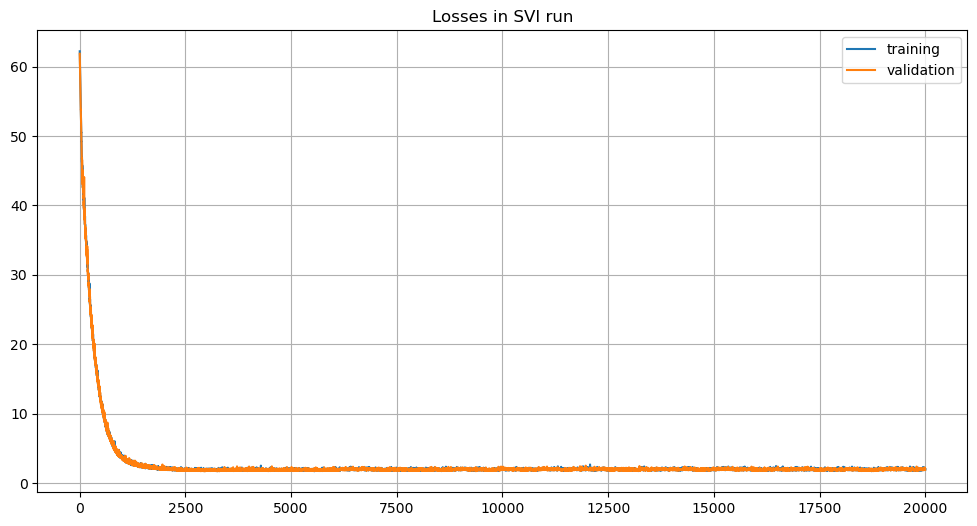

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(training_losses, label='training')
ax.plot(validation_losses, label='validation')
ax.set_title(f'Losses in SVI run')
ax.grid()
ax.legend()
plt.show()

In [14]:
# here, we want to draw samples from the trained model on known X's
import pyro.poutine as poutine

N_SAMPLES = 100
N_POINTS = X.shape[0]

# place holder for predictions.
# at each point, draw samples of the predicted value.
y_preds = torch.zeros((N_POINTS, N_SAMPLES)).to(device)

for s in range(N_SAMPLES):
    # STEP 1: Trace the execution of the prediction guide.
    # The trace records the *value* of the sampled parameters (a, b, log_noise_std).
    # posterior_trace = poutine.trace(posterior_sampler).get_trace(X)
    # NB : here we used the q_phi guide/approximate posterior, and 
    #       did not write a specific simpler posterior sampler
    posterior_trace = poutine.trace(q_phi).get_trace(X)
    
    # STEP 2: Use the Replay Poutine on the Model.
    # This forces the Model to use the parameter values recorded in guide_trace.
    with poutine.replay(trace=posterior_trace):
        # STEP 3: Execute the Model to draw a prediction.
        # Calling model(X) with y=None tells the 'obs' site to draw a sample 
        # (the predicted y) using the replayed (fixed) parameters.
        predicted_y_vector = model(X, y=None) 
    
    # STEP 4: Store the resulting vector of predictions for all N_POINTS
    y_preds[:, s] = predicted_y_vector.squeeze()

print(f"Finished sampling {N_SAMPLES} predictive vectors.")

Finished sampling 100 predictive vectors.


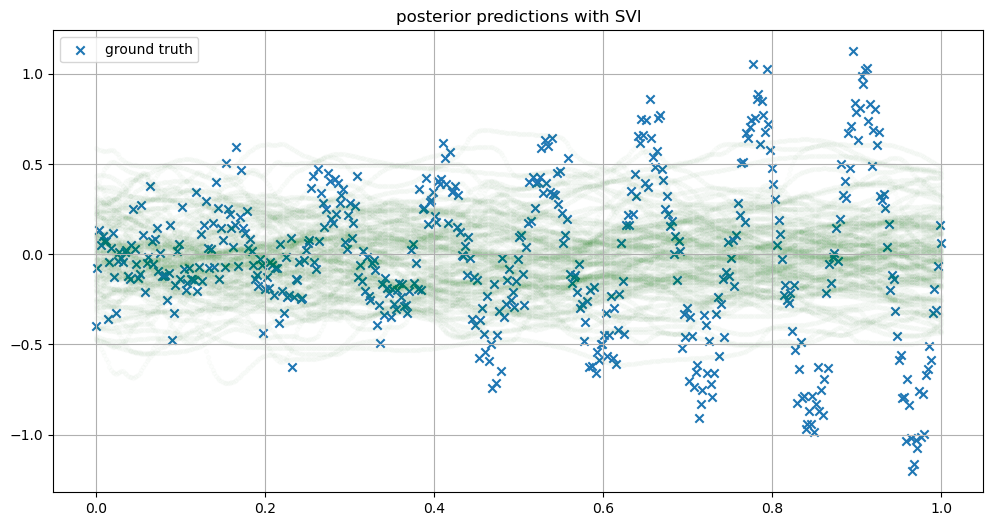

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(X.detach().cpu(),y.detach().cpu(), marker='x', label='ground truth')
ax.grid()
ax.legend()
ax.set_title(f'posterior predictions with SVI')
for s in range(N_SAMPLES):
    ax.scatter(X.cpu(), y_preds[:,s].detach().cpu(), alpha=0.01, color='green', marker='.')
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
3 : MCMC posterior sampling
</div>

In [16]:
# reset the Store parameters
pyro.clear_param_store()

In [17]:
# STEP 1 : define the NUTS kernel - takes the generative model itself.
nuts_kernel = NUTS(
    model=model,
    jit_compile=True, # True for speed, False for debugging
)

In [18]:
# STEP 2 : define a MCMC sampler with the above kernel
# does NOT use the model. This is merely the executor of the MCMCKernel
N_MCMC_SAMPLES = 50
N_BURNIN = 100

MCMC_runner = MCMC(
    kernel=nuts_kernel,
    num_samples=N_MCMC_SAMPLES,
    warmup_steps=N_BURNIN,
    num_chains=4,  # multi chain requires some work in a Jupyter notebook - see code !
    initial_params=None
)

Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/150 [00:00, ?it/s]

In [19]:
# STEP3 : run the sampler
MCMC_runner.run(X,y)

In [20]:
# check effective sample size, etc
# get the dictionnary
# The structure is: {'<RV_name>': {'n_eff': tensor, 'r_hat': tensor, ...}, ...}
diags = MCMC_runner.diagnostics()

# Extract all 'n_eff' tensors
n_eff_list = []
for rv_name, rv_diagnostics in diags.items():
    
    # We only care about n_eff for the parameters we are sampling (weights, biases, sigma)
    # Exclude auxiliary or internal diagnostics if they exist.
    if 'n_eff' in rv_diagnostics and rv_name not in ['_last_state', 'potential_energy']:
        
        # n_eff might be a tensor if the site is multidimensional (like a weight matrix)
        n_eff_tensor = rv_diagnostics['n_eff']
        
        # Flatten the tensor and add all its elements to our list
        n_eff_list.append(n_eff_tensor.flatten())

# Concatenate all n_eff tensors into a single 1D tensor
all_n_eff = torch.cat(n_eff_list)

# Compute the average and minimum ESS
average_n_eff = all_n_eff.mean().item()
min_n_eff = all_n_eff.min().item()

print(f"Total number of stochastic parameters analyzed: {len(all_n_eff)}")
print(f"Overall Average Effective Sample Size (ESS): {average_n_eff:.2f}")
print(f"Minimum Effective Sample Size (ESS): {min_n_eff:.2f}")

Total number of stochastic parameters analyzed: 16834
Overall Average Effective Sample Size (ESS): 2.17
Minimum Effective Sample Size (ESS): 2.02


In [21]:
# extract samples
mcmc_samples = MCMC_runner.get_samples()

# instantiate the predictive with the model and the samples
predictive = Predictive(model, mcmc_samples)

# reconstruction
preds = predictive(X)

# The 'observations' key holds the predictive samples
y_mcmc_samples = preds['observations'] # Shape will be (num_samples, len(X))

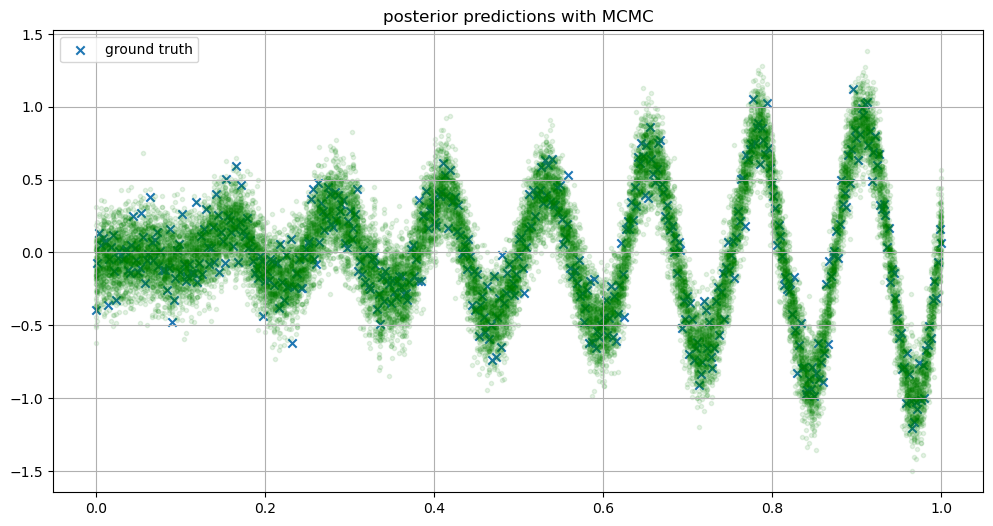

In [22]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(X.detach().cpu(),y.detach().cpu(), marker='x', label='ground truth')
ax.grid()
ax.legend()
ax.set_title(f'posterior predictions with MCMC')
for s in range(N_MCMC_SAMPLES):
    ax.scatter(X.cpu(), y_mcmc_samples[s,:].detach().cpu(), alpha=0.1, color='green', marker='.')
plt.show()